In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
batch_size = 64
img_height = 150
img_width = 150

train_ds = tf.keras.utils.image_dataset_from_directory(
  'train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

valid_ds = tf.keras.utils.image_dataset_from_directory(
  'valid',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  'test',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 80085 files belonging to 500 classes.
Found 2500 files belonging to 500 classes.
Found 2500 files belonging to 500 classes.


In [4]:
class_names = train_ds.class_names
num_classes = len(class_names)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
normalization_layer = layers.Rescaling(1./255)
#normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
#image_batch, labels_batch = next(iter(normalized_ds))
#first_image = image_batch[0]
## Notice the pixel values are now in `[0,1]`.
#print(np.min(first_image), np.max(first_image))

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

# load the ResNet-50 network, ensuring the head FC layer sets are left
# off
print("[INFO] preparing model...")
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(img_height, img_width, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2), strides=(1, 1))(headModel)
headModel = Flatten(name="flatten")(headModel)
#headModel = Dense(1024, activation="softmax")(headModel)
#headModel = Dropout(0.2)(headModel)
headModel = Dense(len(class_names), activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

[INFO] preparing model...


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [8]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/30


c:\Users\user\anaconda3\envs\tf_gpu\lib\site-packages\keras\backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


1252/1252 [==============================] - 180s 103ms/step - loss: 4.6911 - accuracy: 0.5140 - val_loss: 2.4222 - val_accuracy: 0.7248
Epoch 2/30
1252/1252 [==============================] - 122s 97ms/step - loss: 1.3012 - accuracy: 0.8245 - val_loss: 2.5770 - val_accuracy: 0.7380
Epoch 3/30
1252/1252 [==============================] - 124s 99ms/step - loss: 0.8434 - accuracy: 0.8804 - val_loss: 2.6812 - val_accuracy: 0.7580
Epoch 4/30
1252/1252 [==============================] - 120s 96ms/step - loss: 0.7094 - accuracy: 0.9054 - val_loss: 2.8660 - val_accuracy: 0.7772
Epoch 5/30
1252/1252 [==============================] - 119s 95ms/step - loss: 0.6054 - accuracy: 0.9233 - val_loss: 2.8535 - val_accuracy: 0.7864
Epoch 6/30
1252/1252 [==============================] - 120s 96ms/step - loss: 0.5212 - accuracy: 0.9369 - val_loss: 2.9983 - val_accuracy: 0.7904
Epoch 7/30
1252/1252 [==============================] - 119s 95ms/step - loss: 0.4845 - accuracy: 0.9418 - val_loss: 3.4441 - va

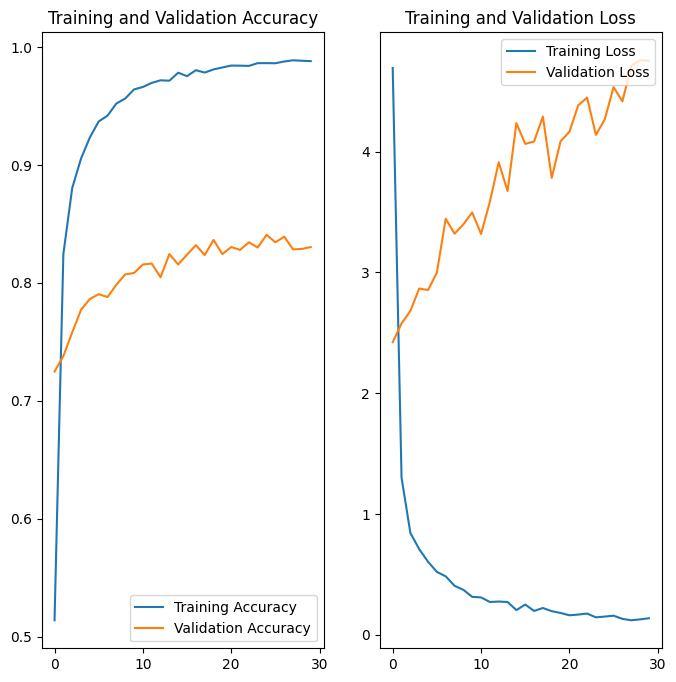

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

40/40 [==============================] - 3s 66ms/step - loss: 3.6431 - accuracy: 0.8480


{'loss': 3.6430916786193848, 'accuracy': 0.8479999899864197}